In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [63]:
round6_tires = {# "goodyear_D0571_18.0x6.5-10_10x6":{"long":None, "lat":None},
# "goodyear_D0571_18.0x6.5-10_10x7":{"long":None, "lat":None},
# "hoosier_LCO_18.0x6.0_10x6":{"long":None, "lat":None},
# "hoosier_LCO_18.0x?0x6.0_10x7":{"long":None, "lat":None},
# "hoosier_r20b_18.0x6.0-10_10x6":{"long":None, "lat":None},
"hoosier_R20_18.0x6.0-10_10x7":{"long":None, "lat":None},
# "hoosier_r25b_18.0x6.0_10x6":{"long":None, "lat":None},
# "hoosier_r25b_18.0x7.5_10x7":{"long":None, "lat":None},
# "hoosier_r25b_18.0x7.5_10x8":{"long":None, "lat":None},
# "mrf_ZTD1_18x6.0-10_10x6":{"long":None, "lat":None},
# "mrf_ZTD1_18x6.0-10_10x7":{"long":None, "lat":None}}
# "avon_7.0-16.0-10_10x7":{"long":None, "lat":None},
# "avon_7.0-16.0-10_10x8":{"long":None, "lat":None},
# "hoosier_LCO_16x6.0-10_10x6":{"long":None, "lat":None},
# "hoosier_LCO_16x6.0-10_10x7":{"long":None, "lat":None},
# "hoosier_LCO_16x7.5-10_10x7":{"long":None, "lat":None},
# "hoosier_LCO_16x7.5-10_10x8":{"long":None, "lat":None},
# "hoosier_r20b_16x6.0-10_10x6":{"long":None, "lat":None},
"hoosier_r20b_16x6.0-10_10x7":{"long":None, "lat":None}}
# "hoosier_r20b_16x7-5_10x8":{"long":None, "lat":None},
# "hoosier_r25b_16x6.0-10_10x6":{"long":None, "lat":None},
# "hoosier_r25b_16x6.0-10_10x7":{"long":None, "lat":None},
# "hoosier_r25b_16x7.5_10x7":{"long":None, "lat":None}}
# "hoosier_r25b_16x7.5_10x8":{"long":None, "lat":None}}

# "hoosier_R20_18.0x6.0-10_10x6":{"long":None, "lat":None},
# "hoosier_R20_18.0x6.0-10_10x7":{"long":None, "lat":None},

camber = 0 # default camber
pressure = 12 * 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
slip_angle = 0
slip_ratio = 0
run_num = 1
normalized_CS = True

In [64]:
for name, tire in round6_tires.items():
    try:
        df = pd.read_csv(f"../tire_data/processed_data/all_tires/braking_{name}.csv")
        tire["long"] = df[(df["pressure"] == pressure) & (df["velocity"] == velocity) & (df["slip"] == slip_angle) & (df["camber"] == camber)]
        
    except:
        print("Error getting long data for {0}".format(name))

    try:
        df = pd.read_csv(f"../tire_data/processed_data/all_tires/cornering_{name}.csv")
        tire["lat"] = df[(df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["SR"] < 1) & (df["SR"] > -1) & (df["camber"] == camber)]

    except:
        print("Error getting lateral data for {0}".format(name))

Error getting long data for hoosier_r20b_16x6.0-10_10x7


In [65]:
loads = set()

for name, tire in round6_tires.items():
    normal = tire["lat"]["load"].unique().tolist()

    for item in normal:
        loads.add(item)

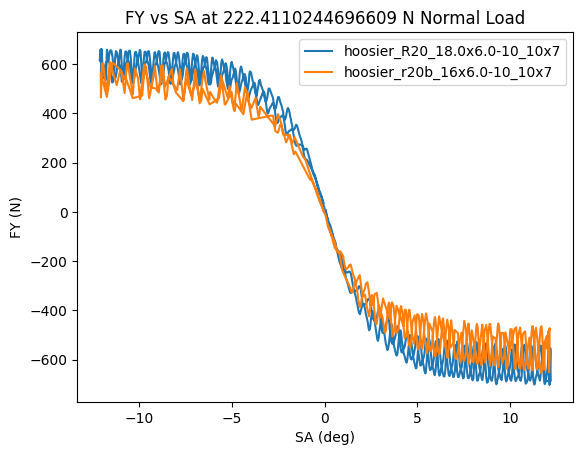

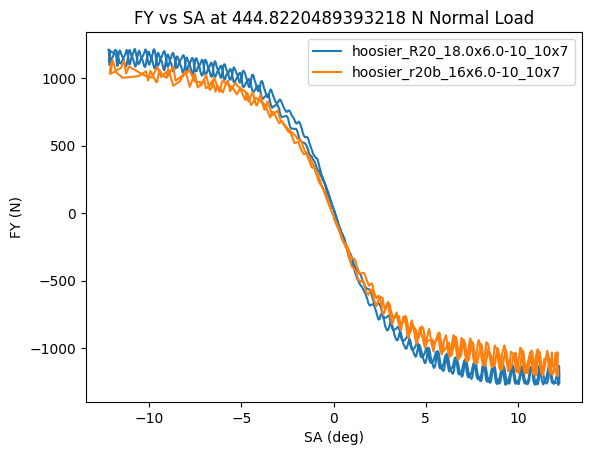

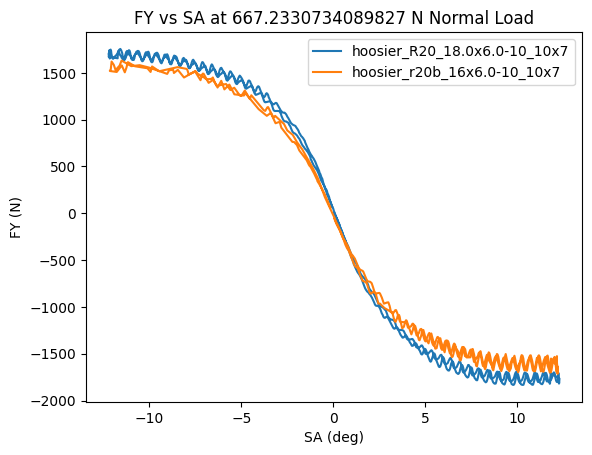

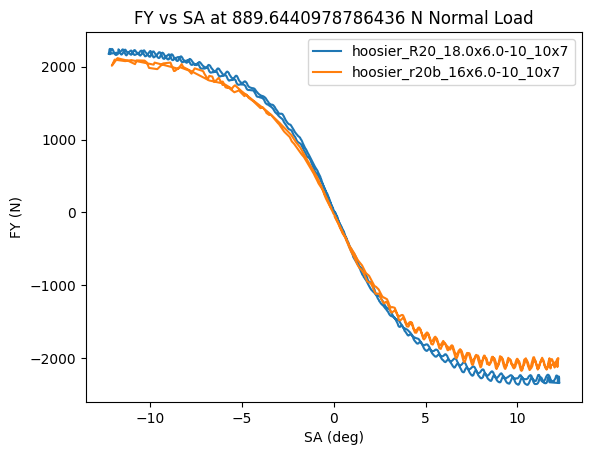

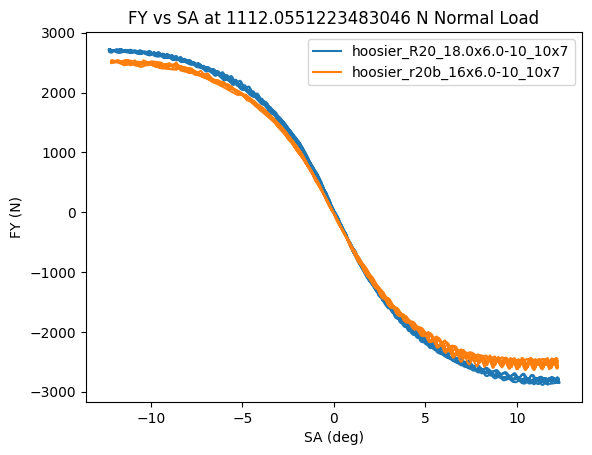

In [66]:
tire_lst = []

normal_loads = []

for item in loads:
    plt.figure()
    for name, tire in round6_tires.items():
        temp = tire["lat"][tire["lat"]["load"] == item]
        plt.plot(temp["SA"], temp["FY"])
        tire_lst.append(name)

        plt.title(f"FY vs SA at {item * -1} N Normal Load")
        plt.xlabel("SA (deg)")
        plt.ylabel("FY (N)")

    plt.legend(tire_lst)

TypeError: 'NoneType' object is not subscriptable

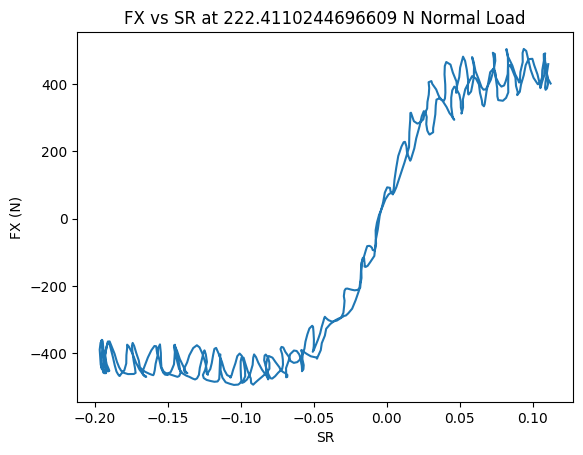

In [62]:
tire_lst = []

for item in [x / 0.224809 for x in [-50, -100, -150, -200, -250]]:
    plt.figure()
    for name, tire in round6_tires.items():
        temp = tire["long"][tire["long"]["load"] == item]
        plt.plot(temp["SR"], temp["FX"])
        tire_lst.append(name)

        plt.title(f"FX vs SR at {item * -1} N Normal Load")
        plt.xlabel("SR")
        plt.ylabel("FX (N)")

    plt.legend(tire_lst)